In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import fipy as fp
from fipy.tools.dump import read
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as p
from fvm_utils import *
import torch

print(torch.cuda.is_available())

True


# Hybrid parameter estimation: linear regression and neural networks

Inspired by some scribbles on a Zoom whiteboard with Danny Seara, see below

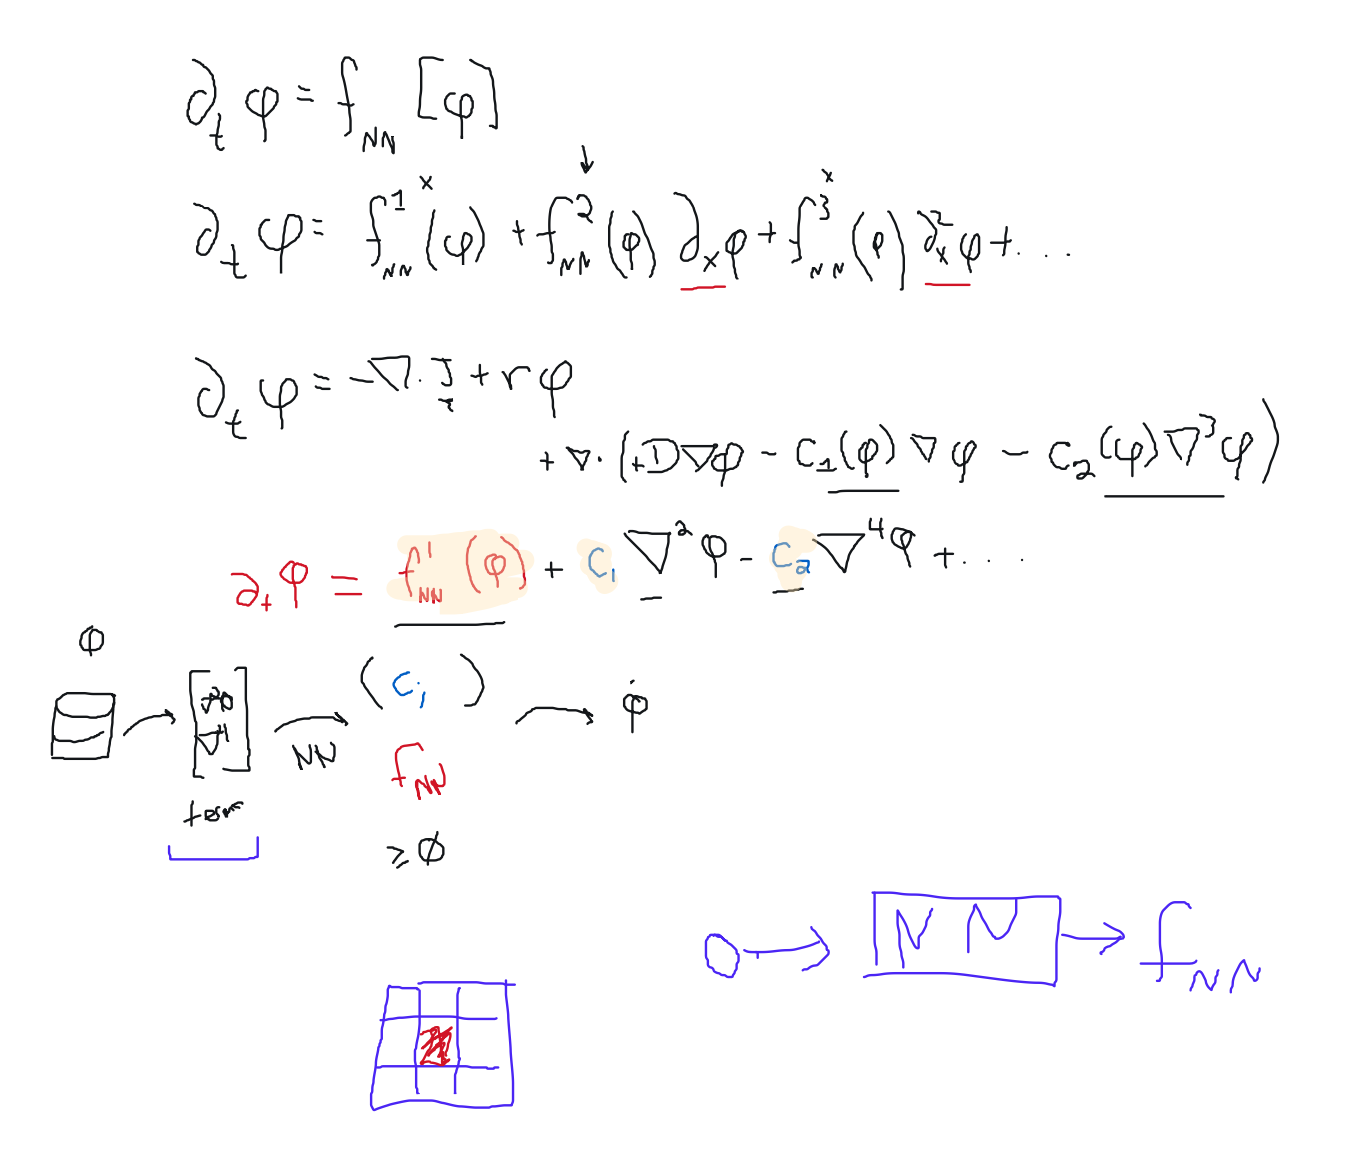

Pre-loading all Fipy data from files
Done (t = 3.9 s)
W0_mesh (776,)
B0_mesh (776,)
W1_mesh (776,)
B1_mesh (776,)
t0 ()
t1 ()
features_mesh List of length 2
X torch.Size([776])
Y torch.Size([776])
W0 (776,)
B0 (776,)
W1 (776,)
B1 (776,)
features torch.Size([2, 7, 776])
dt_W (776,)
dt_B (776,)
inputs torch.Size([2, 776])
targets torch.Size([2, 776])


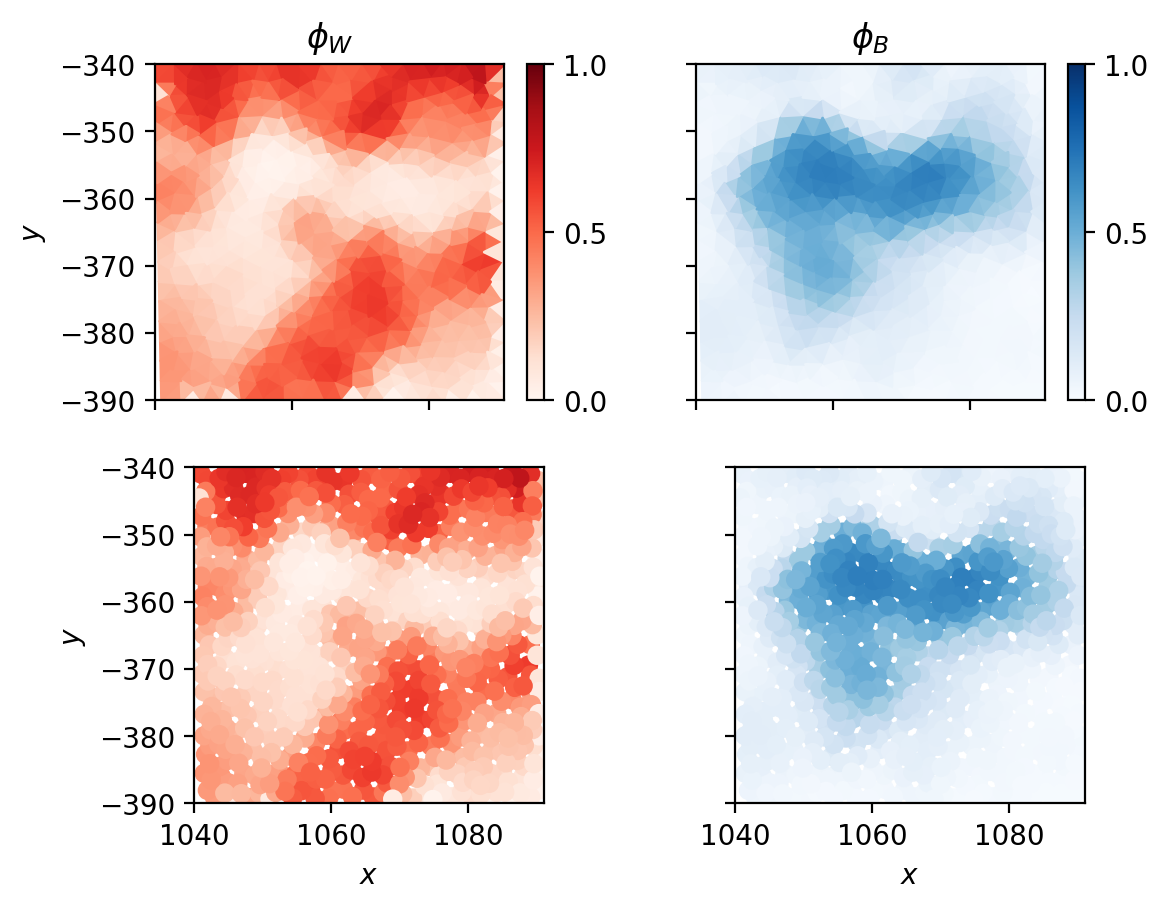

In [2]:
from fipy_dataset import FipyDataset

dataset = FipyDataset(grid=False, remove_extra=False, preload=True)
sample = dataset[5]

for key in sample:
    try:
        print(key, sample[key].shape)
    except:
        if isinstance(sample[key], list):
            print(key, 'List of length', len(sample[key]))
        else:
            print(key, sample[key])

# Plot everything to make sure that things look correct
from fvm_utils import plot_mesh
fig, ax = plt.subplots(2, 2, dpi=200, sharex=True, sharey=True)

# Plot original fipy objects
plot_mesh(sample['W0_mesh'], sample['W0_mesh'].mesh, ax[0, 0], cmap=plt.cm.Reds, vmin=0, vmax=1)
plot_mesh(sample['B0_mesh'], sample['B0_mesh'].mesh, ax[0, 1], cmap=plt.cm.Blues, vmin=0, vmax=1)

# Plot 
try:
    ax[1, 0].pcolormesh(sample['X'], sample['Y'], sample['inputs'][0], cmap='Reds', vmin=0, vmax=1)
    ax[1, 1].pcolormesh(sample['X'], sample['Y'], sample['inputs'][1], cmap='Blues', vmin=0, vmax=1)
except:
    ax[1, 0].scatter(sample['X'], sample['Y'], c=sample['inputs'][0], cmap='Reds', vmin=0, vmax=1)
    ax[1, 1].scatter(sample['X'], sample['Y'], c=sample['inputs'][1], cmap='Blues', vmin=0, vmax=1)

ax[0, 0].set_title('$\\phi_W$')
ax[0, 1].set_title('$\\phi_B$')

ax[0, 0].set_ylabel('$y$')
ax[1, 0].set(xlabel='$x$', ylabel='$y$')
ax[1, 1].set_xlabel('$x$')

for a in ax.flatten():
    a.set_aspect(np.ptp(a.get_ylim()) / np.ptp(a.get_xlim()))

In [3]:
from fipy_nn import SociohydroParameterNetwork, ParameterNetwork
model = SociohydroParameterNetwork()
model.print()

outputs, _ = model(sample['inputs'], sample['features'], batched=False)
print(outputs.shape)                                 

dt ϕW = 1 T_W + 0 k_WW + 0 k_WB + 0 ν_WWW + 0 ν_WWB + 0 ν_WBB + -1 Γ_W + NN(['ϕW', 'ϕB'])
dt ϕB = 1 T_B + 0 k_BB + 0 k_BW + 0 ν_BBB + 0 ν_BWB + 0 ν_BWW + -1 Γ_B + NN(['ϕW', 'ϕB'])
torch.Size([2, 776])


In [4]:
from train_fipy_nn import JointLossFunction

loss = JointLossFunction(beta=1.)

loss(sample['targets'][None],
     sample['targets'][None],
     sample['inputs'][None],
     sample['inputs'][None],
     sample['inputs'][None])

tensor(0.4695)